# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">Sentiment Analysis Locally</div>

In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import re
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
import ast
pd.set_option('display.max_colwidth', 1000)

# Load News Data
## Config

In [2]:
start_date = "2024-01-01"
end_date = "2024-08-30"
folder_path = r"data/fx/"
tag = "EURUSD"
aspect = "EUR"

In [3]:
# Concatenate all DataFrames from the folder
df = pd.read_excel(folder_path+tag+'_q2'+'.xlsx')
#drop empty data and some columns
df = df.dropna(subset=['Title'])

#Set date as index and sort df base on date
df.set_index('Created Date', inplace=True)
df.index = pd.to_datetime('2024 ' + df.index, format='%Y %b %d, %H:%M %Z')
df = df.sort_index()

# Filter the DataFrame based on the time period
df = df.loc[start_date:end_date]
df

,Title,Tag
Created Date,,
2024-04-29 00:50:00+00:00,"EUR/USD holds positive ground above 1.0700, eyes on German CPI data",EURUSD
2024-04-29 06:13:00+00:00,EUR/USD Price Analysis: Keeps steady above 1.0700 amid shift to upward momentum,EURUSD
2024-04-29 14:33:00+00:00,"EUR/USD retreats ahead of Eurozone, US data-packed week",EURUSD
2024-04-29 22:28:00+00:00,EUR/USD finds support near 1.0720 after slow grind on Monday,EURUSD
2024-04-30 04:31:00+00:00,"EUR/USD Price Analysis: Manages to hold above 200-hour SMA ahead of Eurozone CPI, FOMC",EURUSD
...,...,...
2024-08-26 12:55:00+00:00,EUR/USD: Consolidates under 1.12 for a break above – Scotiabank,EURUSD
2024-08-26 13:10:00+00:00,EUR/USD: Bias to fade rally – OCBC,EURUSD
2024-08-26 14:21:00+00:00,"EUR/USD corrects from 1.1200 as Fed, ECB September rate cut bets swell",EURUSD


# Get Sentiment Score
## 1. FinBert

In [4]:
# 初始化 FinBERT 模型
#model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained("models/finbert/tokenizer")
model = AutoModelForSequenceClassification.from_pretrained("models/finbert/model",num_labels=3)
finbert_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def compute_finbert_sentiment(text):
    try:
        chunks = nltk.sent_tokenize(text)
        if len(chunks) == 1:
            result = finbert_model(text)
            label = result[0]['label']
            score = result[0]['score']
            if label == 'Positive':
                return score
            elif label == 'Neutral':
                return 0.0
            elif label == 'Negative':
                return -1.0*score
        else:
            sentiments = []
            for chunk in chunks:
                result = finbert_model(chunk)
                label = result[0]['label']
                score = result[0]['score']
                if label == 'Positive':
                    sentiments.append(score)
                elif label == 'Neutral':
                    sentiments.append(0)
                elif label == 'Negative':
                    sentiments.append(-1*score)
            score = sum(sentiments) / len(sentiments)
            if score > 0:
                positive_values = [val for val in sentiments if val > 0]
                return  sum(positive_values) / len(positive_values)
            elif score < 0:
                negative_values = [val for val in sentiments if val < 0]
                return sum(negative_values) / len(negative_values)
            else:
                return 0.0
    except Exception as e:
        print(f"Error processing text: {e}")
        return np.nan

In [5]:
%%time
df['FinBERT_sentiment_title'] = df['Title'].apply(compute_finbert_sentiment)
df[df['FinBERT_sentiment_title']!=0].head()

CPU times: user 1min 16s, sys: 23 s, total: 1min 39s
Wall time: 12.8 s


,Title,Tag,FinBERT_sentiment_title
Created Date,,,
2024-04-29 00:50:00+00:00,"EUR/USD holds positive ground above 1.0700, eyes on German CPI data",EURUSD,0.794606
2024-04-29 06:13:00+00:00,EUR/USD Price Analysis: Keeps steady above 1.0700 amid shift to upward momentum,EURUSD,0.999999
2024-04-30 14:32:00+00:00,"EUR/USD drops on US Dollar's recovery, steady Eurozone inflation",EURUSD,0.993590
2024-05-01 18:47:00+00:00,"EUR/USD climbs after Fed reaffirms policy outlook, QT taper on the cards",EURUSD,0.808475
2024-05-02 05:06:00+00:00,EUR/USD remains above 1.0700 amid expectations of Fed refraining from further rate hikes,EURUSD,-0.997683


## 2. ABSA_Bert Model
Github: https://github.com/yangheng95/PyABSA
Hugging face: https://huggingface.co/yangheng/deberta-v3-base-absa-v1.1

In [6]:
# Load the ABSA model and tokenizer
#model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained("models/absa/tokenizer", use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained("models/absa/model")
absa_model = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [7]:
def compute_absa_sentiment(text, aspect):
    try:
        chunks = nltk.sent_tokenize(text)
        if len(chunks) == 1:
            result = absa_model(text, text_pair=aspect)
            label = result[0]['label']
            score = result[0]['score']
            if label == 'Positive':
                return score
            elif label == 'Neutral':
                return 0.0
            elif label == 'Negative':
                return -1.0*score
        else:
            sentiments = []
            for chunk in chunks:
                result = absa_model(chunk, text_pair=aspect)
                label = result[0]['label']
                score = result[0]['score']
                if label == 'Positive':
                    sentiments.append(score)
                elif label == 'Neutral':
                    sentiments.append(0)
                elif label == 'Negative':
                    sentiments.append(-1*score)
            score = sum(sentiments) / len(sentiments)
            if score > 0:
                positive_values = [val for val in sentiments if val > 0]
                return  sum(positive_values) / len(positive_values)
            elif score < 0:
                negative_values = [val for val in sentiments if val < 0]
                return sum(negative_values) / len(negative_values)
            else:
                return 0.0
    except Exception as e:
        print(f"Error processing text: {e}")
    return 0.0

In [8]:
%%time
df[f'ABSA_Bert_sentiment_title_{aspect}'] = df['Title'].apply(lambda x: compute_absa_sentiment(x, aspect))
df[df[f'ABSA_Bert_sentiment_title_{aspect}']!=0].head()

CPU times: user 2min 14s, sys: 38.3 s, total: 2min 52s
Wall time: 22 s


,Title,Tag,FinBERT_sentiment_title,ABSA_Bert_sentiment_title_EUR
Created Date,,,,
2024-04-29 00:50:00+00:00,"EUR/USD holds positive ground above 1.0700, eyes on German CPI data",EURUSD,0.794606,0.556653
2024-04-29 14:33:00+00:00,"EUR/USD retreats ahead of Eurozone, US data-packed week",EURUSD,0.000000,-0.694304
2024-04-30 14:32:00+00:00,"EUR/USD drops on US Dollar's recovery, steady Eurozone inflation",EURUSD,0.993590,-0.972448
2024-04-30 23:12:00+00:00,"EUR/USD tumbles out of recent range, tests below 1.0770 as markets flee into safe havens",EURUSD,0.000000,-0.810969
2024-05-01 04:28:00+00:00,EUR/USD drops to near 1.0650 ahead of Fed policy,EURUSD,0.000000,-0.761008


## VaderSentiment

In [9]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to compute sentiment score
def compute_sentiment(text):
    try:
        sentiment = analyzer.polarity_scores(text)
        # Return the compound score which is a normalized score between -1 and 1
        return sentiment['compound']  
    except:
        return 0.0
# Apply the sentiment function to the 'title' and 'content' columns
df['Vader_sentiment_title'] = df['Title'].apply(compute_sentiment)
df[df['Vader_sentiment_title']!=0].head()

,Title,Tag,FinBERT_sentiment_title,ABSA_Bert_sentiment_title_EUR,Vader_sentiment_title
Created Date,,,,,
2024-04-29 00:50:00+00:00,"EUR/USD holds positive ground above 1.0700, eyes on German CPI data",EURUSD,0.794606,0.556653,0.5574
2024-04-29 22:28:00+00:00,EUR/USD finds support near 1.0720 after slow grind on Monday,EURUSD,0.000000,0.000000,0.4019
2024-04-30 23:12:00+00:00,"EUR/USD tumbles out of recent range, tests below 1.0770 as markets flee into safe havens",EURUSD,0.000000,-0.810969,0.4404
2024-05-01 11:01:00+00:00,"EUR/USD finds support near 1.0650, downside remains favored ahead of Fed policy",EURUSD,0.000000,0.000000,0.5423
2024-05-01 14:42:00+00:00,"EUR/USD holds mildly up after US data, Fed looms",EURUSD,0.000000,0.000000,-0.1531


In [10]:
df.to_csv("result/"+tag+'_news_scores.csv')

# Word Cloud
## Data Process

In [11]:
def word_dict(df, word_source_column, score_column):  
    dict = {}
    for index, row in df.iterrows():
        words = re.findall(r'\b\w+\b', row[word_source_column])
        words = set(words)
        score = row[score_column]
        for word in words:
            if word in dict:
                dict[word].append(score)
            else:
                dict[word] = [score]
                
    for word, scores in dict.items():
        average_score = sum(scores) / len(scores)
        dict[word] = (average_score, len(scores))
    return dict
# Initialize an empty dictionary to store words as keys and list of sentiment scores as values

df_Vader = df.dropna(subset=['Vader_sentiment_title'])
df_Vader = df_Vader[df_Vader['Vader_sentiment_title']!=0]

df_ABSA_Bert = df.dropna(subset=[f'ABSA_Bert_sentiment_title_{aspect}'])
df_ABSA_Bert = df_ABSA_Bert[df_ABSA_Bert[f'ABSA_Bert_sentiment_title_{aspect}']!=0]

df_FinBert = df.dropna(subset=['FinBERT_sentiment_title'])
df_FinBert = df_FinBert[df_FinBert['FinBERT_sentiment_title']!=0]

vader_title_word_dict = word_dict(df_Vader, "Title", "Vader_sentiment_title")
absa_title_word_dict = word_dict(df_ABSA_Bert, "Title", f'ABSA_Bert_sentiment_title_{aspect}')
finbert_title_word_dict = word_dict(df_FinBert,"Title","FinBERT_sentiment_title")

In [12]:
from nltk.corpus import stopwords

# Custom stopwords to be added
custom_stopwords = ["will","would","make","made","making","word","take","took","taking","say","says","said","used","use","uses","user","users","using","give","gave","gives","giving",
                    "many","much","company", "companies","come","came","comes","knows","know","knew","known","also","might","whether","see","without","around",
                    "can","could","even","still","help","helps","helped","look","looks","looked","looking","lot"
                    "first","second","third","percent","re","likely","unlikely","city","Plus","one","discusses","search",
                    "day","days""week","weeks","year","years","january","feburary","march","april","may","june","july","august","september","october","november","december"
                    "a", "b", "c", "d", "e", "f", "g", "h", "i","j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

def remove_stopwords(word_score_dict, custom_stopwords=None):
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    
    cleaned_text_dict = {}
    
    for word, (score, freq) in word_score_dict.items():
        if word.lower() not in stop_words and not any(char.isdigit() for char in word):
            cleaned_text_dict[word] = (score, freq)
    
    return cleaned_text_dict

vader_title_word_dict = remove_stopwords(vader_title_word_dict, custom_stopwords)
absa_title_word_dict = remove_stopwords(absa_title_word_dict, custom_stopwords)
finbert_title_word_dict = remove_stopwords(finbert_title_word_dict, custom_stopwords)

In [13]:
def keep_top_n_words(word_score_dict, n):
    top_words = dict(sorted(word_score_dict.items(), key=lambda x: x[1][1], reverse=True)[:n])
    return top_words

# Keep only the top 50 words based on scores
vader_title_word_dict = keep_top_n_words(vader_title_word_dict, 50)
absa_title_word_dict = keep_top_n_words(absa_title_word_dict, 50)
finbert_title_word_dict = keep_top_n_words(finbert_title_word_dict, 50)

In [14]:
# Custom colormap from green to grey to red
custom_cmap = mcolors.LinearSegmentedColormap.from_list('green_grey_red', ['red', 'lightgrey', 'green'])

# Function to map scaled score to color
def score_to_color(score):
    # Normalize the score to be between 0 and 1
    normalized_score = (score + 1) / 2
    # Map the normalized score to a color from green to red
    return mcolors.to_hex(custom_cmap(normalized_score))

## 1. Vader Title Wordcloud

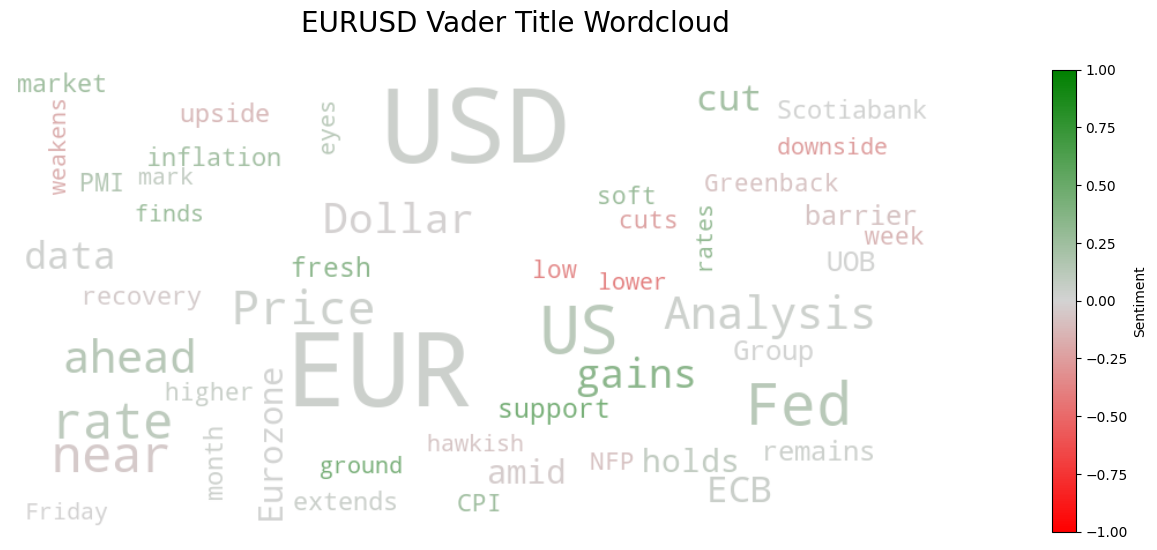

In [15]:
# Generate word cloud based on the count of scores
wordcloud = WordCloud(width=800, height=400, max_font_size=90, min_font_size=20, background_color='white').generate_from_frequencies(
    {word: count for word, (_, count) in vader_title_word_dict.items()}
)
# Color the words based on scaled average score
wordcloud.recolor(color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs:
                  score_to_color(vader_title_word_dict[word][0]))

# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [40, 1]})

plt.suptitle(f'{tag} Vader Title Wordcloud', fontsize=20)

# Plot the word cloud
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis('off')

# Add a color bar to the second subplot
sm = plt.cm.ScalarMappable(cmap=custom_cmap,norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, cax=axs[1])
cbar.set_label('Sentiment')
plt.savefig(f'result/{tag} Vader Title Wordcloud.png')
plt.show()

## 2. Absa Title Wordcloud

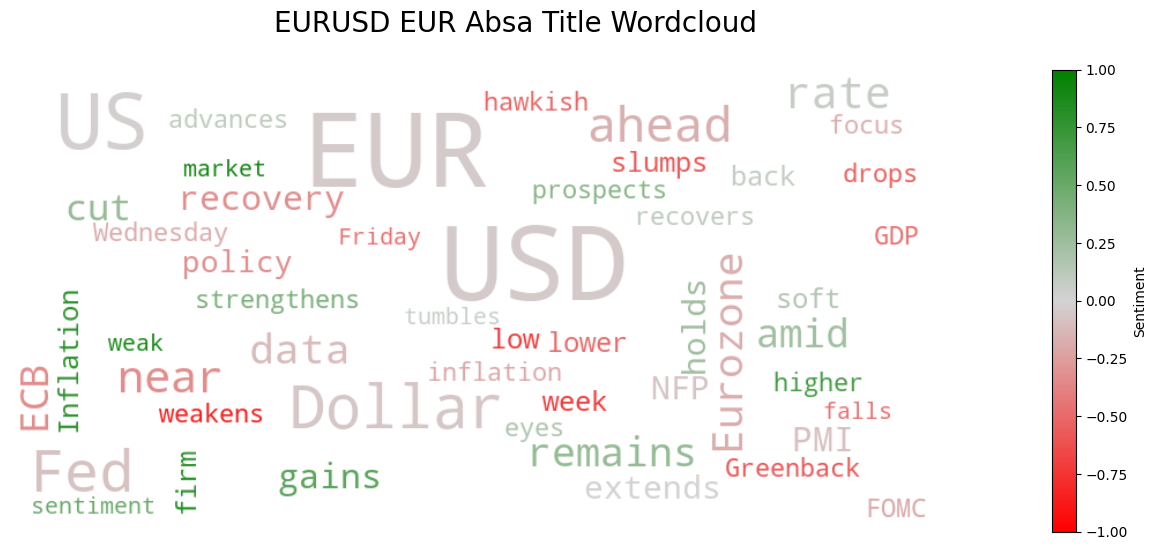

In [16]:
# Generate word cloud based on the count of scores
wordcloud = WordCloud(width=800, height=400, max_font_size=90, min_font_size=20, background_color='white').generate_from_frequencies(
    {word: count for word, (_, count) in absa_title_word_dict.items()}
)
# Color the words based on scaled average score
wordcloud.recolor(color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs:
                  score_to_color(absa_title_word_dict[word][0]))

# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [40, 1]})

plt.suptitle(f'{tag} {aspect} Absa Title Wordcloud', fontsize=20)

# Plot the word cloud
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis('off')

# Add a color bar to the second subplot
sm = plt.cm.ScalarMappable(cmap=custom_cmap,norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, cax=axs[1])
cbar.set_label('Sentiment')
plt.savefig(f'result/{tag} {aspect} Absa Title Wordcloud.png')
plt.show()

## 3. Finbert Title Wordcloud

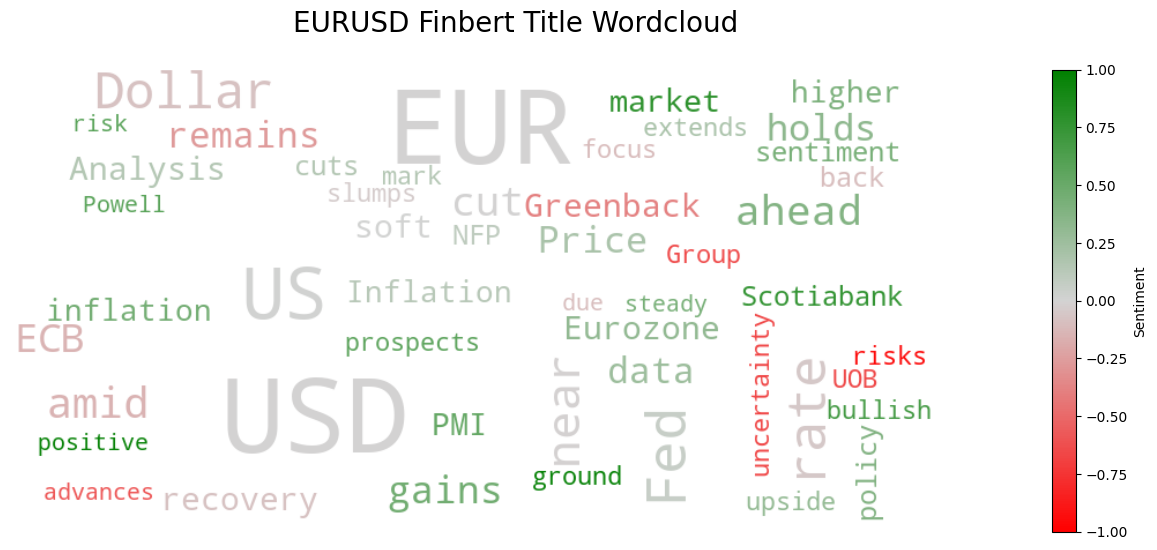

In [17]:
# Generate word cloud based on the count of scores
wordcloud = WordCloud(width=800, height=400, max_font_size=90, min_font_size=20, background_color='white').generate_from_frequencies(
    {word: count for word, (_, count) in finbert_title_word_dict.items()}
)
# Color the words based on scaled average score
wordcloud.recolor(color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs:
                  score_to_color(finbert_title_word_dict[word][0]))

# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [40, 1]})

plt.suptitle(f'{tag} Finbert Title Wordcloud', fontsize=20)

# Plot the word cloud
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis('off')

# Add a color bar to the second subplot
sm = plt.cm.ScalarMappable(cmap=custom_cmap,norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, cax=axs[1])
cbar.set_label('Sentiment')
plt.savefig(f'result/{tag} Finbert Title Wordcloud.png')
plt.show()